In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
import imageio
import pdb

%reload_ext autoreload
%autoreload 2

torch.set_printoptions(linewidth=200)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
from nst_utils import *
model = VGG19_StyleTransfer()

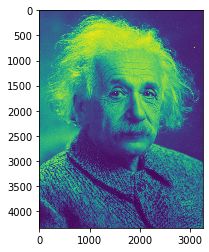

In [3]:
content_image = imageio.imread("Albert_Einstein.jpg")
plt.imshow(content_image);

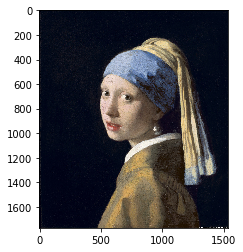

In [4]:
style_image = imageio.imread('girl with a pearl earring.jpg')
plt.imshow(style_image);

In [5]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, C, H, W), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, C, H, W), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    # Retrieve dimensions from a_G (≈1 line)
    m, H, W, C = a_G.shape
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = a_C.view(C, -1) #(C, H*W)
    a_G_unrolled = a_G.view(C, -1) #(C, H*W)
    
    # compute the cost with PyTorch (≈1 line)
    J_content = torch.mean((a_C_unrolled - a_G_unrolled)**2)/4
    
    return J_content

In [6]:
a_C = np.array([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866, -1.9202449, 4.6461368, -1.0375276, 4.899456, -7.5360813, 3.4091651, -0.24858844, -2.4324749, 8.146585, -1.7646906, 2.4694333, -6.5859847, 0.7149899, 0.66104376, 4.199985, 2.5062335, 4.5016236, 1.5636368, 3.4233422, -8.455175, 3.4438267, 1.2252892, 0.23202246, 1.4615504, 4.211294, -4.7429867, -2.338422, 1.3776655, -3.3965898, 0.25865, 1.2512636, 7.4767985, 5.1221766, 10.617524, -1.3393097, 0.99052405, -5.4103217, -5.450125, -1.7732203, -4.097825, 4.843958, 2.7449985])
a_C = torch.tensor(a_C.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
a_G = np.array([-0.39043474, -4.965909, -5.387548, 4.572505, 1.1961036, 5.0099816, 1.7304354, -0.13603461, -0.7514645, -3.0110965, 1.0130516, 7.4561086, 0.51901615, -0.23328066, -0.8221154, 0.69788367, 1.5624137, 0.11127031, 3.7990131, -0.5115707, -5.364818, -4.8868036, -1.1914248, -0.12090659, 7.0109277, -1.2259245, 4.2369, -5.399742, 3.159936, 7.259596, 1.643039, 7.3115473, 0.17630118, -2.8375332, 1.839904, -0.71492875, 5.2510543, 1.4054474, 2.8612938, 2.5214956, 4.3172836, 1.902338, 0.14868057, -1.2611487, -0.78171515, 0.5315, -0.8009285, 3.4972606])
a_G = torch.tensor(a_G.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
J_content = compute_content_cost(a_C, a_G)
print(f'J_content = {J_content}')

J_content = 6.765592868805971


In [7]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (C, H*W)
    
    Returns:
    GA -- Gram matrix of A, of shape (C, C)
    """
    
    GA = torch.mm(A, A.t())
    
    return GA

In [8]:
torch.random.manual_seed(1)
A = torch.tensor([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866]).view(3, 2*1)
GA = gram_matrix(A)
print(f'GA =\n {GA}')

GA =
 tensor([[ 6.4223, -4.4291, -2.0967],
        [-4.4291, 19.4658, 19.5639],
        [-2.0967, 19.5639, 20.6865]])


In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, C, H, W), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, C, H, W), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # Retrieve dimensions from a_G (≈1 line)
    N, C, H, W = a_G.shape
    
    # Reshape the images to have them of shape (C, H*W) (≈2 lines)
    a_S_unrolled = a_S.view(C, -1)
    a_G_unrolled = a_G.view(C, -1)
    
    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S_unrolled)
    GG = gram_matrix(a_G_unrolled)
    
    # Computing the loss (≈1 line)
    J_style_layer = torch.sum((GS - GG)**2)/(4 * C**2 * (H*W)**2)

    return J_style_layer

In [10]:
torch.random.manual_seed(1)
a_S = np.array([-1.683445, 1.8942857, 4.189092, 1.3846824, 3.8925915, 2.3524866, -1.9202449, 4.6461368, -1.0375276, 4.899456, -7.5360813, 3.4091651, -0.24858844, -2.4324749, 8.146585, -1.7646906, 2.4694333, -6.5859847, 0.7149899, 0.66104376, 4.199985, 2.5062335, 4.5016236, 1.5636368, 3.4233422, -8.455175, 3.4438267, 1.2252892, 0.23202246, 1.4615504, 4.211294, -4.7429867, -2.338422, 1.3776655, -3.3965898, 0.25865, 1.2512636, 7.4767985, 5.1221766, 10.617524, -1.3393097, 0.99052405, -5.4103217, -5.450125, -1.7732203, -4.097825, 4.843958, 2.7449985])
a_S = torch.tensor(a_S.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
a_G = np.array([-0.39043474, -4.965909, -5.387548, 4.572505, 1.1961036, 5.0099816, 1.7304354, -0.13603461, -0.7514645, -3.0110965, 1.0130516, 7.4561086, 0.51901615, -0.23328066, -0.8221154, 0.69788367, 1.5624137, 0.11127031, 3.7990131, -0.5115707, -5.364818, -4.8868036, -1.1914248, -0.12090659, 7.0109277, -1.2259245, 4.2369, -5.399742, 3.159936, 7.259596, 1.643039, 7.3115473, 0.17630118, -2.8375332, 1.839904, -0.71492875, 5.2510543, 1.4054474, 2.8612938, 2.5214956, 4.3172836, 1.902338, 0.14868057, -1.2611487, -0.78171515, 0.5315, -0.8009285, 3.4972606])
a_G = torch.tensor(a_G.reshape([1, 4, 4, 3]).transpose([0, 3, 1, 2]))
J_style_layer = compute_layer_style_cost(a_S, a_G)
print(f'J_style_layer = {J_style_layer}')

J_style_layer = 9.190277771775303


In [11]:
print(model)
style_layers = [0, 5, 10, 19, 28]
style_layer_coeffs = [0.2, 0.2, 0.2, 0.2, 0.2]

VGG19_StyleTransfer(
  (features): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), str

In [12]:
def compute_style_cost(style_layers, style_layer_coeffs, generated_im_results, style_im_results):
    """
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_num, coeff in zip(style_layers, style_layer_coeffs):
        # Compute style_cost for the current layer
        a_S = style_im_results[layer_num]
        a_G = generated_im_results[layer_num]
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [13]:
def get_costs(model, content_im_results, style_im_results, style_layers, style_layer_coeffs, content_layer, generated_image):
    generated_im_results = model(generated_image)
    
    #Compute content cost
    a_C = content_im_results[content_layer]
    a_G = generated_im_results[content_layer]
    J_content = compute_content_cost(a_C, a_G)
    
    J_style = compute_style_cost(style_layers, style_layer_coeffs, generated_im_results, style_im_results)
    
    return J_content, J_style

In [14]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha*J_content + beta*J_style
    
    return J

In [15]:
content_image = imageio.imread("Albert_Einstein_small.jpg")
content_image = reshape_and_normalize_image(content_image)

In [16]:
style_image = imageio.imread("girl with a pearl earring_small.jpg")
style_image = reshape_and_normalize_image(style_image)

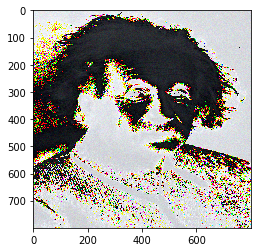

In [17]:
generated_image = generate_noise_image(content_image)
plt.imshow(np.transpose(generated_image, (0, 2, 3, 1))[0].astype(np.uint8));

In [18]:
content_layer = 21
model = VGG19_StyleTransfer(layers=style_layers + [content_layer])
content_image = torch.tensor(content_image).float().to(device)
style_image = torch.tensor(style_image).float().to(device)
generated_image = torch.tensor(generated_image).float().to(device)
model = model.to(device)

In [19]:
optimizer = optim.Adam([generated_image.requires_grad_()], lr=2.0)

In [20]:
torch.cuda.empty_cache()

In [21]:
content_im_results = model(content_image)
style_im_results = model(style_image)

In [22]:
for layer in content_im_results.keys():
    content_im_results[layer] = content_im_results[layer].detach()
    style_im_results[layer] = style_im_results[layer].detach()

In [23]:
params = {
    'model': model,
    'style_layers': style_layers,
    'style_layer_coeffs': style_layer_coeffs,
    'content_layer': content_layer,
    'generated_image': generated_image,
    'content_im_results': content_im_results,
    'style_im_results': style_im_results
}

In [24]:
def train(model, style_layers, style_layer_coeffs, content_layer, generated_image,
          content_im_results, style_im_results, num_iterations=200):
    
    for i in range(num_iterations):
        # Print every 20 iteration.
        Jc, Js = get_costs(model, content_im_results, style_im_results, style_layers, style_layer_coeffs, content_layer, generated_image)
        optimizer.zero_grad()
        Jt = total_cost(Jc, Js)
        Jt.backward()
        optimizer.step()
        if i%50 == 0:
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt.item()))
            print("content cost = " + str(Jc.item()))
            print("style cost = " + str(Js.item()))
            
            # save current generated image in the "/output" directory
            save_image(str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('generated_image.jpg', generated_image)

In [25]:
def save_image(path, image):
    # Un-normalize the image so that it looks good
    image = image.detach().cpu().numpy().transpose(0, 2, 3, 1)
    image += CONFIG.MEANS
    image = np.clip(image[0], 0, 255).astype('uint8')
    
    imageio.imsave(path, image)

In [26]:
train(**params, num_iterations=5000);

Iteration 0 :
total cost = 1075660672.0
content cost = 525.6810913085938
style cost = 26891386.0
Iteration 50 :
total cost = 412935936.0
content cost = 1051.494384765625
style cost = 10323135.0
Iteration 100 :
total cost = 279874752.0
content cost = 1111.8076171875
style cost = 6996591.0
Iteration 150 :
total cost = 175026992.0
content cost = 1118.8983154296875
style cost = 4375395.0
Iteration 200 :
total cost = 87952840.0
content cost = 1099.3013916015625
style cost = 2198546.25
Iteration 250 :
total cost = 36673736.0
content cost = 1092.802734375
style cost = 916570.25
Iteration 300 :
total cost = 13559212.0
content cost = 1093.407958984375
style cost = 338706.9375
Iteration 350 :
total cost = 6828559.5
content cost = 1090.897705078125
style cost = 170441.265625
Iteration 400 :
total cost = 3582249.0
content cost = 1116.1688232421875
style cost = 89277.1796875
Iteration 450 :
total cost = 2276556.75
content cost = 1138.5421142578125
style cost = 56629.28125
Iteration 500 :
total cost

Iteration 4000 :
total cost = 408498.15625
content cost = 1370.0810546875
style cost = 9869.93359375
Iteration 4050 :
total cost = 410019.75
content cost = 1358.836669921875
style cost = 9910.7841796875
Iteration 4100 :
total cost = 561871.9375
content cost = 1381.701171875
style cost = 13701.3740234375
Iteration 4150 :
total cost = 421085.3125
content cost = 1364.0953369140625
style cost = 10186.1083984375
Iteration 4200 :
total cost = 1308567.875
content cost = 1308.630615234375
style cost = 32387.041015625
Iteration 4250 :
total cost = 434995.65625
content cost = 1367.8929443359375
style cost = 10532.91796875
Iteration 4300 :
total cost = 472950.40625
content cost = 1370.82861328125
style cost = 11481.052734375
Iteration 4350 :
total cost = 670176.25
content cost = 1381.2982177734375
style cost = 16409.08203125
Iteration 4400 :
total cost = 521804.4375
content cost = 1338.7060546875
style cost = 12710.4345703125
Iteration 4450 :
total cost = 580802.0
content cost = 1374.669677734375